# Boosting

CatBoost vs. LightGBM vs. XGBoost

https://cienciadedatos.net/documentos/py09_gradient_boosting_python

# Gradient Boosting Trees

Un modelo Gradient Boosting Trees está formado por un conjunto (ensemble) de árboles de decisión individuales, entrenados de forma secuencial. Cada nuevo árbol emplea información del árbol anterior para aprender de sus errores, mejorando iteración a iteración. 

Los métodos de ensemble combinan múltiples modelos en uno nuevo con el objetivo de lograr un equilibro entre bias y varianza, consiguiendo así mejores predicciones que cualquiera de los modelos individuales originales. Dos de los tipos de ensemble más utilizados son:

    Bagging: se ajustan múltiples modelos, cada uno con un subconjunto distinto de los datos de entrenamiento. Para predecir, todos los modelos que forman el agregado participan aportando su predicción. Como valor final, se toma la media de todas las predicciones (variables continuas) o la clase más frecuente (variables categóricas). Los modelos Random Forest están dentro de esta categoría.

    Boosting: se ajustan secuencialmente múltiples modelos sencillos, llamados weak learners, de forma que cada modelo aprende de los errores del anterior. En el caso de Gradient Boosting Trees, los weak learners se consiguen utilizando árboles con una o pocas ramificaciones. Como valor final, al igual que en bagging, se toma la media de todas las predicciones (variables continuas) o la clase más frecuente (variables cualitativas). Tres de los algoritmos de boosting más empleados son AdaBoost, Gradient Boosting y Stochastic Gradient Boosting. Todos ellos se caracterizan por tener una cantidad considerable de hiperparámetros, cuyo valor óptimo se tiene que identificar mediante validación cruzada. Tres de los más importantes son:

        El número de weak learners o número de iteraciones: a diferencia del bagging y random forest, el boosting puede sufrir overfitting si este valor es excesivamente alto. Para evitarlo, se emplea un término de regularización conocido como learning rate.

        Learning rate: controla la influencia que tiene cada weak learner en el conjunto del ensemble, es decir, el ritmo al que aprende el modelo. Suelen recomendarse valores de 0.001 o 0.01, aunque la elección correcta puede variar dependiendo del problema. Cuanto menor sea su valor, más árboles se necesitan para alcanzar buenos resultados pero menor es el riesgo de overfitting.

        Si los weak learners son árboles, el tamaño máximo permitido de cada árbol. Suelen emplearse valores pequeños, entre 1 y 10.

Forma en que consiguen reducir el error total. El error total de un modelo puede descomponerse como bias+varianza+ϵ. En bagging, se emplean modelos con muy poco bias pero mucha varianza, agregándolos se consigue reducir la varianza sin apenas inflar el bias. En boosting, se emplean modelos con muy poca varianza pero mucho bias, ajustando secuencialmente los modelos se reduce el bias. Por lo tanto, cada una de las estrategias reduce una parte del error total.

In [1]:


# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
import sklearn
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings

print(f"Versión de scikit-learn: {sklearn.__version__}")



Versión de scikit-learn: 1.5.2


In [2]:


# Descarga de datos
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/Boston.csv'
)
datos = pd.read_csv(url, sep=',')
datos.head(3)



,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7


In [3]:


# División de los datos en entrenamiento y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "MEDV"),
                                        datos['MEDV'],
                                        random_state = 123
                                    )
# Creación del modelo
# ==============================================================================
modelo = HistGradientBoostingRegressor(
            max_iter     = 10,
            loss         = 'squared_error',
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)



HistGradientBoostingRegressor(max_iter=10, random_state=123)

In [9]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

rmse = root_mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones
       )
r2=r2_score(y_true=y_test, y_pred=predicciones)

print(f"El error (rmse) de test es: {rmse}")
print(f"El r2 de test es: {r2}")


El error (rmse) de test es: 5.175175457179093
El r2 de test es: 0.6607337007190386


# Optimización de hiperparámetros


## Número de árboles


En Gradient Boosting, el número de árboles es un hiperparámetro crítico en cuanto que, con forme se añaden árboles, se incrementa el riesgo de sobreajuste (overfitting).


## Learning rate


Junto con el número de árboles, el learning_rate es el hiperparámetro más importantes en Gradient Boosting, ya que es el que permite controlar cómo de rápido aprende el modelo y con ello el riesgo de llegar al overfitting. Estos dos hiperparámetros son interdependientes, cuanto menor es el learning rate, más árboles se necesitan para alcanzar buenos resultados pero menor es el riesgo de overfitting. Cuanto mayor es el valor del learning rate, más rápido aprende el modelo pero antes puede aparecer el overfitting.

## Max depth

La profundidad de los árboles (max_depth) en los modelos Gradient Boosting suele ser un valor muy bajo, haciendo así que cada árbol solo pueda aprender un pequeña parte de la relación entre predictores y variable respuesta (weak learner).



  Tip
Cuando los recursos computacionales (o tiempo) son limitados, es aconsejable seguir una de las siguientes estrategias para identificar los hiperparámetros óptimos de un modelo Gradient Boosting:

    Fijar el número de árboles y optimizar el learning rate.

    Fijar el learning rate y añadir tantos árboles como sea necesario pero activando la parada temprana para evitar overfitting.

Una vez identificados los valores de estos hiperparámetros, se refinan el resto.

### Grid Search basado en validación cruzada

In [10]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'loss'             : ['squared_error', 'absolute_error'],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'max_depth'        : [3, 5, 10, 20],
              'l2_regularization': [0, 1, 10]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = HistGradientBoostingRegressor(
                        max_iter            = 1000, 
                        random_state        = 123,
                        # Activación de la parada temprana
                        early_stopping      = True,
                        validation_fraction = 0.1,
                        n_iter_no_change    = 10,
                        tol                 = 1e-7,
                        scoring             = 'loss',
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_l2_regularization,param_learning_rate,param_loss,param_max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
43,1,0.1,squared_error,20,-3.669431,0.448214,-2.337653,0.595595
42,1,0.1,squared_error,10,-3.669431,0.448214,-2.337653,0.595595
17,0,0.1,squared_error,5,-3.716610,0.384398,-2.406267,0.574598
18,0,0.1,squared_error,10,-3.771660,0.454215,-2.478086,0.451284


In [11]:


# Número de árboles del modelo final (early stopping)
# ==============================================================================
print(f"Número de árboles del modelo: {grid.best_estimator_.n_iter_}")



Número de árboles del modelo: 50


In [14]:


# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = root_mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones
       )
r2=r2_score(y_true=y_test, y_pred=predicciones)

print(f"El error (rmse) de test es: {rmse}")
print(f"El r2 de test es: {r2}")

El error (rmse) de test es: 4.125497064570422
El r2 de test es: 0.7844027935248729


In [15]:
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
11,5.446604,0.288384,LSTAT
5,4.903891,0.176809,RM
7,0.856145,0.080632,DIS
4,0.847798,0.065242,NOX
0,0.465227,0.030585,CRIM
6,0.335038,0.046341,AGE
10,0.308566,0.026022,PTRATIO
9,0.230401,0.033951,TAX
2,0.155159,0.013061,INDUS
8,0.093236,0.014850,RAD


# XGBoost y LighGBM
## XGBoost

A diferencia de las implementaciones nativas de scikit-learn, en XGBoost y LightGBM, el conjunto de validación para la parada temprana, no se extrae automáticamente. Para poder integrar la parada temprana con el GridSearchCV() o RandomizedSearchCV() y que no haya observaciones que participan en ambos procesos, se tiene que separar manualmente un conjunto de validación del de entrenamiento.


In [16]:


# Instalación XGBoost: pip install xgboost
from xgboost import XGBRegressor
## Ojo, el XGBoost de random forest es XGBRFRegressor


# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'max_depth'        : [None, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'booster'          : ['gbtree']
             }


# Crear conjunto de validación
# ==============================================================================
np.random.seed(123)
idx_validacion = np.random.choice(
                    X_train.shape[0],
                    size=int(X_train.shape[0]*0.1), #10% de los datos de entrenamiento 
                    replace=False
                 )

X_val = X_train.iloc[idx_validacion, :].copy()
y_val = y_train.iloc[idx_validacion].copy()

X_train_grid = X_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()
y_train_grid = y_train.reset_index(drop = True).drop(idx_validacion, axis = 0).copy()

# XGBoost necesita pasar los paramétros específicos del entrenamiento al llamar
# al método .fit()
fit_params = {
              "eval_set": [(X_val, y_val)],
              "verbose": False
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = XGBRegressor(
                        n_estimators          = 1000,
                        early_stopping_rounds = 5,
                        eval_metric           = "rmse",
                        random_state          = 123
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_grid, y = y_train_grid, **fit_params)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

C:\Users\PC1\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,param_booster,param_learning_rate,param_max_depth,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
32,gbtree,0.10,10,0.5,-3.788404,0.596132,-1.027006,0.371860
34,gbtree,0.10,20,0.5,-3.828822,0.600352,-1.135829,0.545670
20,gbtree,0.01,10,0.5,-3.866705,0.599838,-1.602501,0.398608
24,gbtree,0.10,None,0.5,-3.869064,0.590603,-1.638464,0.268059


In [20]:


# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")



El error (rmse) de test es: 4.1326656546767015


C:\Users\PC1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [17]:


# Instalación LightGBM: pip install lightgbm
from lightgbm.sklearn import LGBMRegressor



# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators'     : [100, 500, 1000, 5000],
              'max_depth'        : [-1, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'boosting_type'    : ['gbdt']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = LGBMRegressor(random_state=123),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_grid, y = y_train_grid)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 342, number of used features: 11
[LightGBM] [Info] Start training from score 22.481579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

C:\Users\PC1\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,param_boosting_type,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
114,gbdt,0.10,3,500,0.5,-3.803656,0.772055,-1.071614,0.104883
115,gbdt,0.10,3,500,1.0,-3.803656,0.772055,-1.071614,0.104883
71,gbdt,0.01,3,5000,1.0,-3.804875,0.765501,-1.125871,0.119525
70,gbdt,0.01,3,5000,0.5,-3.804875,0.765501,-1.125871,0.119525


In [19]:


# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test,)
rmse = root_mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones
       )
print(f"El error (rmse) de test es: {rmse}")



El error (rmse) de test es: 4.1326656546767015


In [1]:


# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings

print(f"Versión de scikit-learn: {sklearn.__version__}")



NameError: name 'sklearn' is not defined

In [2]:


# Lectura de datos
# ==============================================================================
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")
datos = carseats.data
print(carseats.__doc__)



.. container::

   .. container::

      ======== ===============
      Carseats R Documentation
      ======== ===============

      .. rubric:: Sales of Child Car Seats
         :name: sales-of-child-car-seats

      .. rubric:: Description
         :name: description

      A simulated data set containing sales of child car seats at 400
      different stores.

      .. rubric:: Usage
         :name: usage

      .. code:: R

         Carseats

      .. rubric:: Format
         :name: format

      A data frame with 400 observations on the following 11 variables.

      ``Sales``
         Unit sales (in thousands) at each location

      ``CompPrice``
         Price charged by competitor at each location

      ``Income``
         Community income level (in thousands of dollars)

      ``Advertising``
         Local advertising budget for company at each location (in
         thousands of dollars)

      ``Population``
         Population size in region (in thousands)

      ``Pric

A diferencia del ejemplo previo, en estos datos se incluyen variables categóricas. Aunque todas las librerías empleadas en este documento son capaces de manejar variables categóricas de manera nativa, en algunos modelos o implementaciones podría ser necesario aplicar la técnica de *one-hot-encoding*. La sección titulada **Variables Categóricas** proporciona un detallado análisis del uso de estas variables con cada una de las bibliotecas. 

In [4]:
datos['ventas_altas'] = np.where(datos.Sales > 8, 0, 1)
# Una vez creada la nueva variable respuesta se descarta la original
datos = datos.drop(columns = 'Sales')

# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'ventas_altas'),
                                        datos['ventas_altas'],
                                        random_state = 123
                                    )

# Ordinal encoding de las variables categóricas
# ==============================================================================
# Se identifica el nobre de las columnas categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# HistGradientBoostingClassifier requiere que los valores de categoría se codifiquen
# en [0, n_unique_categories - 1], por lo que se utiliza un OrdinalEncoder para
# preprocesar los datos. Los valores missing se codifican como -1. Si una nueva
# categoría se encuentra en el conjunto de test se codifica como -1.
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = make_column_transformer(
                        (
                            OrdinalEncoder(
                                dtype=int,
                                handle_unknown="use_encoded_value",
                                unknown_value=-1,
                                encoded_missing_value=-1
                            ),
                            cat_cols
                        ),
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 170 to 365
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ShelveLoc    300 non-null    int64
 1   Urban        300 non-null    int64
 2   US           300 non-null    int64
 3   CompPrice    300 non-null    int64
 4   Income       300 non-null    int64
 5   Advertising  300 non-null    int64
 6   Population   300 non-null    int64
 7   Price        300 non-null    int64
 8   Age          300 non-null    int64
 9   Education    300 non-null    int64
dtypes: int64(10)
memory usage: 25.8 KB


In [5]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {
    'max_iter'      : [50, 100, 500, 1000],
    'max_depth'     : [3, 5, 10, 20],
    'learning_rate' : [0.001, 0.01, 0.1]
}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = HistGradientBoostingClassifier(random_state=123, categorical_features=cat_cols),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train_prep, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_learning_rate,param_max_depth,param_max_iter,mean_test_score,std_test_score,mean_train_score,std_train_score
38,0.1,5,500,0.843333,0.054365,1.0,0.0
34,0.1,3,500,0.836667,0.061824,1.0,0.0
39,0.1,5,1000,0.836667,0.049889,1.0,0.0
43,0.1,10,1000,0.833333,0.062361,1.0,0.0


In [7]:
modelo_final = grid.best_estimator_
modelo_final

HistGradientBoostingClassifier(categorical_features=['ShelveLoc', 'Urban',
                                                     'US'],
                               max_depth=5, max_iter=500, random_state=123)

In [8]:


# Error de test del modelo final
# ==============================================================================
predicciones = modelo_final.predict(X = X_test_prep)
predicciones[:10]



array([0, 1, 0, 0, 0, 0, 1, 1, 1, 1])

Matriz de confusión
-------------------
[[38 12]
 [ 5 45]]

El accuracy de test es: 83.0 %
              precision    recall  f1-score   support

           0       0.88      0.76      0.82        50
           1       0.79      0.90      0.84        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



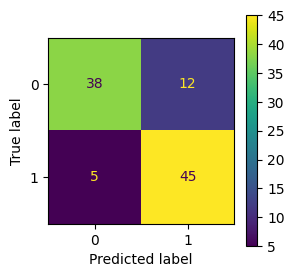

In [12]:
from sklearn.metrics import classification_report

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")
fig, ax = plt.subplots(figsize=(3, 3))
ConfusionMatrixDisplay(mat_confusion).plot(ax=ax);
print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)


# LightGBM


LightGBM permite tanto la detección automática basada en el tipo de las columnas como indicar qué columnas se deben tratar como categorías (siempre que hayan sido previamente codificadas como número esteros). A continuación, se muestran las dos aproximaciones.

Codificar las categorías como números enteros y especificar explícitamente los nombres de las variables categóricas (recomendado)


In [13]:
from lightgbm import LGBMClassifier

# Lectura de datos
# ==============================================================================
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")
datos = carseats.data
datos['ventas_altas'] = np.where(datos.Sales > 8, 0, 1)
# Una vez creada la nueva variable respuesta se descarta la original
datos = datos.drop(columns = 'Sales')

# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'ventas_altas'),
                                        datos['ventas_altas'],
                                        random_state = 123
                                    )

# Ordinal encoding de las variables categóricas
# ==============================================================================
# Se utiliza un OrdinalEncoder para preprocesar los datos. Los valores missing se
# codifican como -1. Si una nueva categoría se encuentra en el conjunto de test
# se codifica como -1.
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
preprocessor = make_column_transformer(
                        (
                            OrdinalEncoder(
                                dtype=int,
                                handle_unknown="use_encoded_value",
                                unknown_value=-1,
                                encoded_missing_value=-1
                            ),
                            cat_cols
                        ),
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                   ).set_output(transform="pandas")

# Una vez que se ha definido el objeto ColumnTransformer, con el método fit()
# se aprenden las transformaciones con los datos de entrenamiento y se aplican a
# los dos conjuntos con transform(). Ambas operaciones a la vez con fit_transform().
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [14]:


# Entreanmiento del modelo
# ==============================================================================
modelo = LGBMClassifier(
            n_estimators = 100,
            random_state = 123
         )

# En los modelos LGBMRegressor y LGBMClassifier, el argumento categorical_feature
#  se especifica en el método fit y no durante su inicialización.
modelo.fit(X = X_train_prep, y = y_train, categorical_feature=cat_cols)



[LightGBM] [Info] Number of positive: 186, number of negative: 114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 300, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.620000 -> initscore=0.489548
[LightGBM] [Info] Start training from score 0.489548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LGBMClassifier(random_state=123)

## Detección automática variables categóricas

In [15]:
# Lectura de datos
# ==============================================================================
carseats = sm.datasets.get_rdataset("Carseats", "ISLR")
datos = carseats.data
datos['ventas_altas'] = np.where(datos.Sales > 8, 0, 1)
# Una vez creada la nueva variable respuesta se descarta la original
datos = datos.drop(columns = 'Sales')

# Convertir las variables no numéricas a tipo category
# ==============================================================================
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
datos[cat_cols] = datos[cat_cols].astype('category')

# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = 'ventas_altas'),
                                        datos['ventas_altas'],
                                        random_state = 123
                                    )

# Entreanmiento del modelo
# ==============================================================================
modelo = LGBMClassifier(
            n_estimators = 100,
            random_state = 123
         )

# En los modelos LGBMRegressor y LGBMClassifier, el argumento categorical_feature
#  se especifica en el método fit y no durante su inicialización.
modelo.fit(X = X_train, y = y_train, categorical_feature='auto')

[LightGBM] [Info] Number of positive: 186, number of negative: 114
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 300, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.620000 -> initscore=0.489548
[LightGBM] [Info] Start training from score 0.489548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(random_state=123)

# Gradient Boosting Monótono

Los modelos basados en Gradient Boosting son capaces de aprender interacciones complejas entre los predictores y la variable respuesta. Esto puede convertirse en una desventaja cuando, debido al ruido de los datos, el modelo aprende comportamientos que no reflejan la realidad. Una estrategia para evitar este tipo de problemas consiste en forzar a que la relación de cada predictor (numérico) con la variable respuesta sea monótona, es decir tenga siempre la misma dirección (positiva o negativa).

Aunque el algoritmo es más complejo, a grandes rasgos, se consigue una relación monótona respecto a una determinada variable si, además de otros criterios, solo se permiten divisiones de nodos cuando el valor medio del nodo hijo derecho es mayor que el nodo hijo izquierdo (o a la inversa si se quiere una relación negativa).

Si se dispone de suficiente conocimiento sobre el problema en cuestión como para saber que la relación entre predictor y variable es monótona, forzar el comportamiento puede resultar en un modelo con mayor capacidad de generalizar a nuevas observaciones. Las clases HistGradientBoosting tiene un argumento llamado monotonic_cst que recibe una lista de longitud igual al número de predictores del modelo, con valores +1 para monotonía positiva, -1 para negativa y 0 para no restricciones. Esta misma característica tambien esta dispobible en XGBoost, LightGBM y H2O.

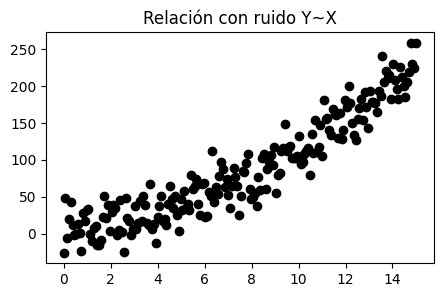

In [16]:


x = np.linspace(start=0, stop=15, num=200)
y = x**2 + 10



y = y  + np.random.normal(loc=0, scale=20, size=y.shape)

fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(x, y, color = "black")
ax.set_title('Relación con ruido Y~X');





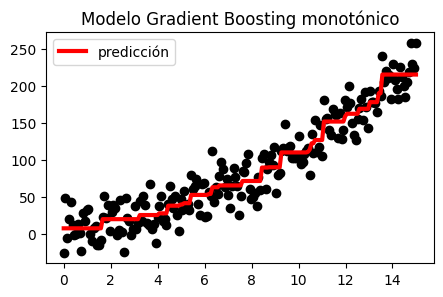

In [18]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Modelo Gradient Boosting Trees con 
modelo_gbm_monotonic = HistGradientBoostingRegressor(max_iter=500, max_depth=5, monotonic_cst=[1])
modelo_gbm_monotonic.fit(x.reshape(-1, 1), y)

# Predicciones
prediccion_gbm_monotonic = modelo_gbm_monotonic.predict(x.reshape(-1, 1))

# Gráfico
fig, ax = plt.subplots(figsize=(5, 3))
ax.scatter(x, y, color = "black")
ax.plot(x, prediccion_gbm_monotonic, color = "red", label = "predicción", linewidth=3)
ax.set_title("Modelo Gradient Boosting monotónico")
plt.legend();

# Comparación Gradient Boosting y Random Forest


Random Forest se compara con frecuencia con otro algoritmo basado en árboles, Gradient Boosting Trees. Ambos métodos son muy potentes y la superioridad de uno u otro depende del problema al que se apliquen. Algunos aspectos a tener en cuenta son:

    Gracias al out-of-bag error, el método de Random Forest no necesita recurrir a validación cruzada para la optimización de sus hiperparámetros. Esto puede ser una ventaja muy importante cuando los requerimientos computacionales son limitantes. Esta característica también está presente en Stochastic Gradient Boosting pero no en AdaBoost y Gradient Boosting.

    Random forest tiene menos hiperparámetros, lo que hace más sencillo su correcta implementación.

    Si existe una proporción alta de predictores irrelevantes, Random Forest puede verse perjudicado, sobre todo a medida que se reduce el número de predictores ($m$) evaluados. Supóngase que, de 100 predictores, 90 de ellos no aportan información (son ruidos). Si el hiperparámetro $m$ es igual a 3 (en cada división se evalúan 3 predictores aleatorios), es muy probable que los 3 predictores seleccionados sean de los que no aportan nada. Aun así, el algoritmo seleccionará el mejor de ellos, incorporándolo al modelo. Cuanto mayor sea el porcentaje de predictores no relevantes, mayor la frecuencia con la que esto ocurre, por lo que los árboles que forman el Random Forest contendrán predictores irrelevantes. Como consecuencia, se reduce su capacidad predictiva. En el caso de Gradient Boosting Trees, siempre se evalúan todos los predictores, por lo que los no relevantes se ignoran.

    En Random Forest, cada modelo que forma el ensemble es independiente del resto, esto permite que el entrenamiento sea paralelizable.

    Random Forest no sufre problemas de overfitting por muchos árboles que se agreguen.

    Si se realiza una buena optimización de hiperparámetros, Gradient Boosting Trees suele obtener resultados superiores.

    El tamaño final de los modelos Gradient Boosting Trees suele ser menor.

    Gradient Boosting Trees suele ser más rápido prediciendo.
